In [1]:
%load_ext autoreload
%autoreload 2

In [64]:
import os
import sys
import json
import logging
from itertools import chain

import requests
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

from dvidutils import LabelMapper
from libdvid import DVIDNodeService

from neuclease.dvid import *
from neuclease.merge_table import normalize_recarray_inplace, generate_focused_assignment
from neuclease.bin.adjust_focused_points import adjust_focused_points

In [3]:
handler = logging.StreamHandler(sys.stdout)
root_logger = logging.getLogger()
root_logger.handlers = []
root_logger.addHandler(handler)
root_logger.setLevel(logging.INFO)
logging.getLogger('kafka').setLevel(logging.WARNING)

In [4]:
pwd

'/nrs/flyem/bergs/complete-ffn-agglo'

In [16]:
analysis_node = ('emdata3:8900', '662e')
master_node = ('emdata3:8900', '7254f5a8aacf4e6f804dcbddfdac4f7f')

In [6]:
analysis_mapping = fetch_complete_mappings(*analysis_node, 'segmentation')
analysis_mapper = LabelMapper(analysis_mapping.index.values, analysis_mapping.values)

Reading kafka messages from kafka.int.janelia.org:9092 for emdata3:8900 / 662e / segmentation
Reading 149462 kafka messages took 8.116905212402344 seconds
Fetching http://emdata3:8900/api/node/662e/segmentation/mappings...
Fetching http://emdata3:8900/api/node/662e/segmentation/mappings took 0:00:32.737639
Parsing mapping...
Parsing mapping took 0:00:09.443706
Constructing missing identity-mappings...
Constructing missing identity-mappings took 0:00:21.295255


### Load neo4j-defined important bodies; append final splits

In [ ]:
# This list was generated from node 52f9
important_bodies_path = '/nrs/flyem/bergs/complete-ffn-agglo/bodies-0.5-from-neuprint-52f9.csv'
important_bodies = pd.read_csv(important_bodies_path, header=0, usecols=['bodyId'], dtype=np.uint64)['bodyId']
important_bodies = set(important_bodies)

# Read last set of new bodies (from analysis node, after neo4j was loaded).
msgs = read_kafka_messages(*analysis_node, 'segmentation', 'split', 'leaf-only')
final_new_bodies = set(chain(*((msg['Target'], msg['NewLabel']) for msg in msgs)))

# Append final set
important_bodies |= final_new_bodies

### Load edges

In [113]:
dtype = { 'id_a': np.uint64, 'id_b': np.uint64,
          'xa': np.int32, 'ya': np.int32, 'za': np.int32,
          'xb': np.int32, 'yb': np.int32, 'zb': np.int32 }

df = pd.read_csv('hemibrain_662edc_equivs_from_epoints_0.95.csv',
                       names=list(dtype.keys()), header=None, dtype=dtype)
table = df.to_records(index=False)
del df

cols_a = ['id_a', 'xa', 'ya', 'za']
cols_b = ['id_b', 'xb', 'yb', 'zb']
normalize_recarray_inplace(table, 'id_a', 'id_b', cols_a, cols_b)
epoint_df = pd.DataFrame(table)

epoint_df[['xa', 'ya', 'za']] *= 4
epoint_df[['xb', 'yb', 'zb']] *= 4

epoint_df['body_a'] = analysis_mapper.apply(epoint_df['id_a'].values, True)
epoint_df['body_b'] = analysis_mapper.apply(epoint_df['id_b'].values, True)

print(f"Loaded {len(epoint_df)} edges")

Loaded 698895 edges


### Drop non-important (one-hop only)

In [103]:
epoint_onehop_df = epoint_df.query('body_a in @important_bodies and body_b in @important_bodies')
print(f"Kept {len(epoint_onehop_df)} out of {len(epoint_df)} edges")

Kept 13701 out of 698895 edges


### Load previously assigned

In [ ]:
instances = """\
focused_assign
focused_complete
focused_complete_01
focused_complete_02
focused_complete_03
""".split()

all_assigned = []
for instance in tqdm_notebook(instances):
    keys = fetch_keys(*master_node, instance)
    def _edges():
        for key in keys:
            a,b = key.split('_')
            yield (int(a), int(b))
    edges = np.asarray(list(_edges()), np.uint64)
    edges.sort(axis=1)
    all_assigned.append(edges)

assigned_df = pd.DataFrame(np.concatenate(all_assigned), columns=['id_a', 'id_b'])
assigned_df['body_a'] = analysis_mapper.apply(assigned_df['id_a'].values, True)
assigned_df['body_b'] = analysis_mapper.apply(assigned_df['id_b'].values, True)

### Drop previously assigned

In [104]:
epoint_bodies = epoint_onehop_df[['body_a', 'body_b']]
assigned_bodies = assigned_df[['body_a', 'body_b']]

drop_flags = pd.concat((epoint_bodies, assigned_bodies)).duplicated(keep='last')
unassigned_epoint_df = epoint_onehop_df.iloc[~drop_flags[:len(epoint_onehop_df)].values]
drop_count = len(epoint_onehop_df) - len(unassigned_epoint_df)
print(f"Dropped {drop_count} previously assigned edges, kept {len(unassigned_epoint_df)}")

Dropped 3237 previously assigned edges, kept 10464


### Generate sample assignment

In [105]:
np.random.seed(0)
random_edges = np.random.choice(unassigned_epoint_df.index.values, 100, False)
assignment_table = unassigned_epoint_df.loc[random_edges]

assignment_json = generate_focused_assignment(assignment_table, filename)
adjusted_assignment_data = adjust_focused_points(*analysis_node, 'segmentation',
                                                 assignment_json, supervoxels=True,
                                                 max_search_scale=3)

filename = 'hemibrain_662edc_equivs_from_epoints_0.95-SAMPLE-ASSIGNMENT.json'
with open(filename, 'w') as f:
    json.dump(adjusted_assignment_data, f, indent=2)

print(f"Wrote to {os.path.abspath(filename)}")

HBox(children=(IntProgress(value=0), HTML(value='')))


Wrote to /nrs/flyem/bergs/complete-ffn-agglo/hemibrain_662edc_equivs_from_epoints_0.95-SAMPLE-ASSIGNMENT.json


In [106]:
!grep misplaced hemibrain_662edc_equivs_from_epoints_0.95-SAMPLE-ASSIGNMENT.json | wc -l

42


### Tabulate Chris's decisions

In [109]:
chris_node = ('emdata1:8400', '363f')

In [110]:
decisions = []
for row in assignment_table.itertuples(index=False):
    key = f"{row.id_a}+{row.id_b}"
    decision = fetch_key(*chris_node, 'segmentation_merged', key, as_json=True)
    decisions.append([row.id_a, row.id_b, decision["result"]])

decisions = pd.DataFrame(decisions, columns=['id_a', 'id_b', 'decision'])

In [111]:
decisions['decision'].value_counts()

merge         55
dontMerge     44
mergeLater     1
Name: decision, dtype: int64

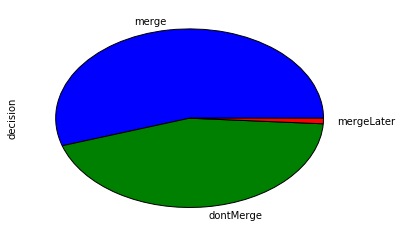

In [112]:
decisions['decision'].value_counts().plot(kind='pie')

In [67]:
import ipykernel.iostream
from tqdm import tqdm, tqdm_notebook

def tqdm_proxy(iterable, *, logger=None, level=logging.INFO, **kwargs):
    """
    Useful as an (almost) drop-in replacement for tqdm which can be used
    in EITHER an interactive console OR a script that logs to file.
    
    Automatically detects whether or not sys.stdout is a file or a console,
    and configures tqdm accordingly.
    
    Example:

        for i in tqdm_proxy(range(1000)):
            # do some stuff
    """
    assert 'file' not in kwargs, \
        "There's no reason to use this function if you are providing your own output stream"
    
    _tqdm = tqdm
    if isinstance(sys.stdout, ipykernel.iostream.OutStream):
        kwargs['file'] = sys.stdout
        _tqdm = tqdm_notebook
    elif os.isatty(sys.stdout.fileno()):
        kwargs['file'] = sys.stdout
    else:
        if logger is None:
            frame = inspect.stack()[1]
            modname = inspect.getmodulename(frame[1])
            if modname:
                logger = logging.getLogger(modname)
            else:
                logger = logging.getLogger("unknown")
        kwargs['file'] = TqdmToLogger(logger, level)

        if 'ncols' not in kwargs:
            kwargs['ncols'] = 100
        
        if 'miniters' not in kwargs:
            # Aim for 5% updates
            if 'total' in kwargs:
                kwargs['total'] = kwargs['total'] // 20

    return _tqdm(iterable, **kwargs)

In [73]:
import os
import json
import copy
import logging
import argparse

import numpy as np

from neuclease import configure_default_logging
from neuclease.util import Timer
from neuclease.dvid import fetch_mapping, fetch_labelarray_voxels
from neuclease.misc import find_best_plane

def adjust_focused_points(server, uuid, instance, assignment_json_data, supervoxels=True, max_search_scale=3):
    new_assignment_data = copy.deepcopy(assignment_json_data)
    new_tasks = new_assignment_data["task list"]

    for task in tqdm_proxy(new_tasks):
        sv_1 = task["supervoxel ID 1"]
        sv_2 = task["supervoxel ID 2"]
        
        coord_1 = np.array(task["supervoxel point 1"])
        coord_2 = np.array(task["supervoxel point 2"])
        
        if supervoxels:
            label_1 = sv_1
            label_2 = sv_2
        else:
            label_1, label_2 = fetch_mapping(server, uuid, instance, [sv_1, sv_2])
        
        avg_coord = (coord_1 + coord_2) // 2
        
        # Search until we find a scale in which the two touch, or give up.
        for scale in range(1+max_search_scale):
            box_xyz = ( avg_coord // (2**scale) - 64,
                        avg_coord // (2**scale) + 64 )
            box_zyx = np.array(box_xyz)[:,::-1]
            seg_vol = fetch_labelarray_voxels(server, uuid, instance, box_zyx, scale, supervoxels=supervoxels)
            
            adjusted_coords_zyx = find_best_plane(seg_vol, label_1, label_2)
            adjusted_coords_zyx = np.array(adjusted_coords_zyx)

            if not (adjusted_coords_zyx == -1).all():
                # Found it.
                adjusted_coords_zyx += box_zyx[0]
                adjusted_coords_zyx *= (2**scale)
                break

        if (adjusted_coords_zyx == -1).all():
            task["coordinate-status"] = "misplaced"
        else:
            task["supervoxel point 1"] = adjusted_coords_zyx[0, ::-1].tolist()
            task["supervoxel point 2"] = adjusted_coords_zyx[1, ::-1].tolist()
            task["coordinate-status"] = f"adjusted-at-scale-{scale}"
    
    return new_assignment_data
    